# Fik 4 log parsing example

This notebook is an example of how to parse and plot data logged by Fik 4 instruments. First, a couple of functions are defined, then those functions are used to read the logs.

In [1]:
import numpy as np
import pandas as pd
import sys
from matplotlib import pyplot as plt

def try_float(v):
    try:
        return float(v)
    except ValueError:
        return float("NaN")

def try_int(v):
    try:
        return int(v)
    except ValueError:
        return -1

def gprmc_date(date):
    if date.strip() == "":
        return None
    
    date = int(date)
    
    return pd.Timestamp(
            year=2000+int(date % 100),
            month=int(date//1e2) % 100,
            day=int(date // 1e4),
            tz='UTC'
    )

def gprmc_time(time):
    if time.strip() == "":
        return None

    time = float(time)
    return pd.Timedelta(
        value = int(1000*(time%100)) \
            + 1000*60*(int(time//1e2) % 100) \
            + 1000*3600*int(time//1e4),
        unit = 'millisecond'
    )

def degmin(s):
    try:
        s = float(s)
    except ValueError:
        return float("NaN")
    
    return (s%100)/60 + int(s)//100


def sum_every_n(s, N):
    assert isinstance(s, pd.Series)
    a = np.array(s.array)
    a = np.sum(a[:len(a)//N*N].reshape((-1, N)), axis=1)
     
    return pd.Series(data=a, index=s.index.array[N//2:len(a)*N:N])


def parse_series(lines, header, fields=[]):
    last_msg = dict()
    series = []
    
    def get_fields(v, r, t):
        try:
            if isinstance(r, int):
                return t(v[r])
            else:
                return np.array(list(map(t, v[r[0]:r[1]])))
        except IndexError:
            return None
        
    
    for l in lines:
        h = l.strip().split(",", 2)[0]
        if h != header:
            last_msg[h] = l
            continue
        v = l.strip().split(",")
        
        series.append([
            get_fields(v, f[1], f[2]) if (isinstance(f[1], int) or isinstance(f[1], tuple)) \
                else get_fields(last_msg.get(f[1], "").split(","), f[2], f[3]) 
            for f in fields
        ])

    return pd.DataFrame(data=series,
                        columns=[f[0] for f in fields])


def read_gnss_lines(lines):
    headers = headers_present(lines)

    gnss_time_msg = '$GPRMC' if '$GPRMC' in headers else '$GNRMC'
    gnss_pos_msg = '$GPGGA' if '$GPGGA' in headers else '$GNGGA'

    t = parse_series(lines, '$TIME', [
        ('Time', 1, try_float),
        ('GNSSTime', gnss_time_msg, 1, gprmc_time),
        ('GNSSDate', gnss_time_msg, 9, gprmc_date)
    ]).dropna()

    if len(t) > 0 and '$TIME' in headers:
        start_ts = t.iloc[-1]['GNSSDate'] \
                    + t.iloc[-1]['GNSSTime'] \
                    - pd.Timedelta(seconds=t.iloc[-1]['Time'])
    else:
        start_ts = None

    nav = parse_series(lines, '$TIME', [
        ('Lat', gnss_pos_msg, 2, degmin),
        ('LatNS', gnss_pos_msg, 3, lambda k: -1 if k == "S" else 1),
        ('Lon', gnss_pos_msg, 4, degmin),
        ('LonEW', gnss_pos_msg, 5, lambda k: -1 if k == "W" else 1),
        ('Alt', gnss_pos_msg, 9, try_float),
        ('Time', 1, try_float),
        ('Speed', gnss_time_msg, 7, try_float)
    ])
    nav = pd.DataFrame({
        'Lat': nav['Lat'] * nav['LatNS'],
        'Lon': nav['Lon'] * nav['LonEW'],
        'Alt': nav['Alt'],
        'Time': nav['Time'],
        'Speed': nav['Speed']*1.852
    }).dropna()

    return (start_ts, nav)


def read_datalog_lines(filename, greetingstart='$AIRDOS'):
    '''
    Reads a DATALOG.TXT file and splits it by instrument runs.

    Each run is represented by tuple of
        (1) the first (greeting) line of the run
        (2) list of other log lines from the run
    '''
    ret = []
    last_greeting = ""
    lines_accum = []

    with open(filename, 'r') as f:
        for l in f:
            l = l.strip()
            if l == "":
                continue
            if l.startswith(greetingstart):
                if lines_accum:
                    ret.append((last_greeting, lines_accum))
                lines_accum = []
                last_greeting = l
            else:
                lines_accum.append(l)
    
    if lines_accum:
        ret.append((last_greeting, lines_accum))

    return ret
 
def headers_present(lines):
    '''Returns list of distinct message headers seen in the passed log lines'''
    ret = set()
    for l in lines:
        h = l.strip().split(",", 2)[0]
        if not h.startswith('$'):
            sys.stderr.write("Warning: In %s, skipping line: %s\n" % (filename, l.strip()))
            continue
        ret.add(h)
    return ret


def _read_airdos_cf_log(greeting, lines):
    assert '$AIRDOS,CF' in greeting

    headers = headers_present(lines)
    if 'Error' in headers:
        sys.stderr.write('Error message seen')

    candy = parse_series(lines, '$CANDY', [
        ('MeasNo', 1, try_int),
        ('Time', 2, try_float),
        ('Sync', 3, try_int),
        ('Pressure', 4, try_float),
        ('Temp', 5, try_float),
        ('Supress', 6, try_int),
        ('Flux', 7, try_int),
        ('Offset', 8, try_int),
        ('Bins', (9, 9+252), try_int)
    ]).dropna()

    start_ts, nav = read_gnss_lines(lines)

    if start_ts is not None:
        nav.index = start_ts + pd.to_timedelta(nav['Time'], unit='sec')
        candy.index = start_ts + pd.to_timedelta(candy['Time'], unit='sec')

    return (nav, candy)

def read_airdos_cf_log(filename, mergeruns=False):
    ret = [
        _read_airdos_cf_log(greeting, lines)
        for greeting, lines in read_datalog_lines(filename)
    ]

    # Inverts the levels of nested arrays
    ret = tuple(zip(*ret))

    if mergeruns:
        return tuple(map(pd.concat, ret))
    else:
        return ret

def _read_airdos_ff_log(greeting, lines):
    assert '$AIRDOS,FF' in greeting

    headers = headers_present(lines)
    if 'Error' in headers:
        sys.stderr.write('Error message seen')

    candy = parse_series(lines, '$CANDY', [
        ('MeasNo', 1, try_int),
        ('Time', 2, try_float),
        ('Sync', 3, try_int),
        ('Supress', 4, try_int),
        ('Flux', 5, try_int),
        ('Offset', 6, try_int),
        ('Bins', (7, 7+252), try_int)
    ]).dropna()

    return (candy, )

def read_airdos_ff_log(filename, mergeruns=False):
    ret = [
        _read_airdos_ff_log(greeting, lines)
        for greeting, lines in read_datalog_lines(filename)
    ]

    # Inverts the levels of nested arrays
    ret = tuple(zip(*ret))

    if mergeruns:
        return tuple(map(pd.concat, ret))
    else:
        return ret

def _read_airdos_gm_log(greeting, lines):
    assert '$AIRDOS,GM' in greeting

    gm = parse_series(lines, '$GM', [
        ('MeasNo', 1, try_int),
        ('Time', 2, try_float),
        ('GMCount', 3, try_int),
        ('Humid', 5, try_float),
        ('Temp', 4, try_float)
    ]).dropna()
    gm = gm[gm['Time'] > 0]

    start_ts, nav = read_gnss_lines(lines)

    if start_ts is not None:
        nav.index = start_ts + pd.to_timedelta(nav['Time'], unit='sec')
        gm.index = start_ts + pd.to_timedelta(gm['Time'], unit='sec')
    else:
        sys.stderr.write('No fix for run of %d lines at %s\n' % (len(lines), greeting))

    return (nav, gm)

def read_airdos_gm_log(filename, mergeruns=False):
    ret = [
        _read_airdos_gm_log(greeting, lines)
        for greeting, lines in read_datalog_lines(filename)
    ]

    # Inverts the levels of nested arrays
    ret = tuple(zip(*ret))

    if mergeruns:
        return tuple(map(pd.concat, ret))
    else:
        return ret

In [2]:
gm_nav, gm = \
    read_airdos_gm_log("DATALOG-GM.TXT", mergeruns=True)
airdos_c_nav, airdos_c_flux = \
    read_airdos_cf_log("DATALOG-AIRDOS_C.TXT", mergeruns=True)
spacedos_flux, = \
    read_airdos_ff_log("DATALOG-SPACEDOS.TXT", mergeruns=True)

airdos_c_nav_ = airdos_c_nav.dropna()

# set SPACEDOS's timestamping based on AIRDOS C's navigation data
spacedos_flux.index = airdos_c_nav_.index[0] - pd.to_timedelta(airdos_c_nav_.iloc[0]['Time'], unit='sec') \
                 + pd.to_timedelta(spacedos_flux['Time'], unit='sec')

## Display raw data
- __AIRDOS C__ - AIRDOS C with CRY-19 scintillator and SiPM
- __SPACEDOS__ - SPACEDOS02A 
- __GM__ - G-M tube counter with an AIRDOS logger
    * __Temperature__ at bottom of payload box (from GM logger)
    * __Humidity__ at bottom of payload box (from GM logger)
    * __Atmospheric Pressure__ in scintillator box (from AIRDOS C logger)
    * __Temperature__ in scintillator box (from AIRDOS C logger)

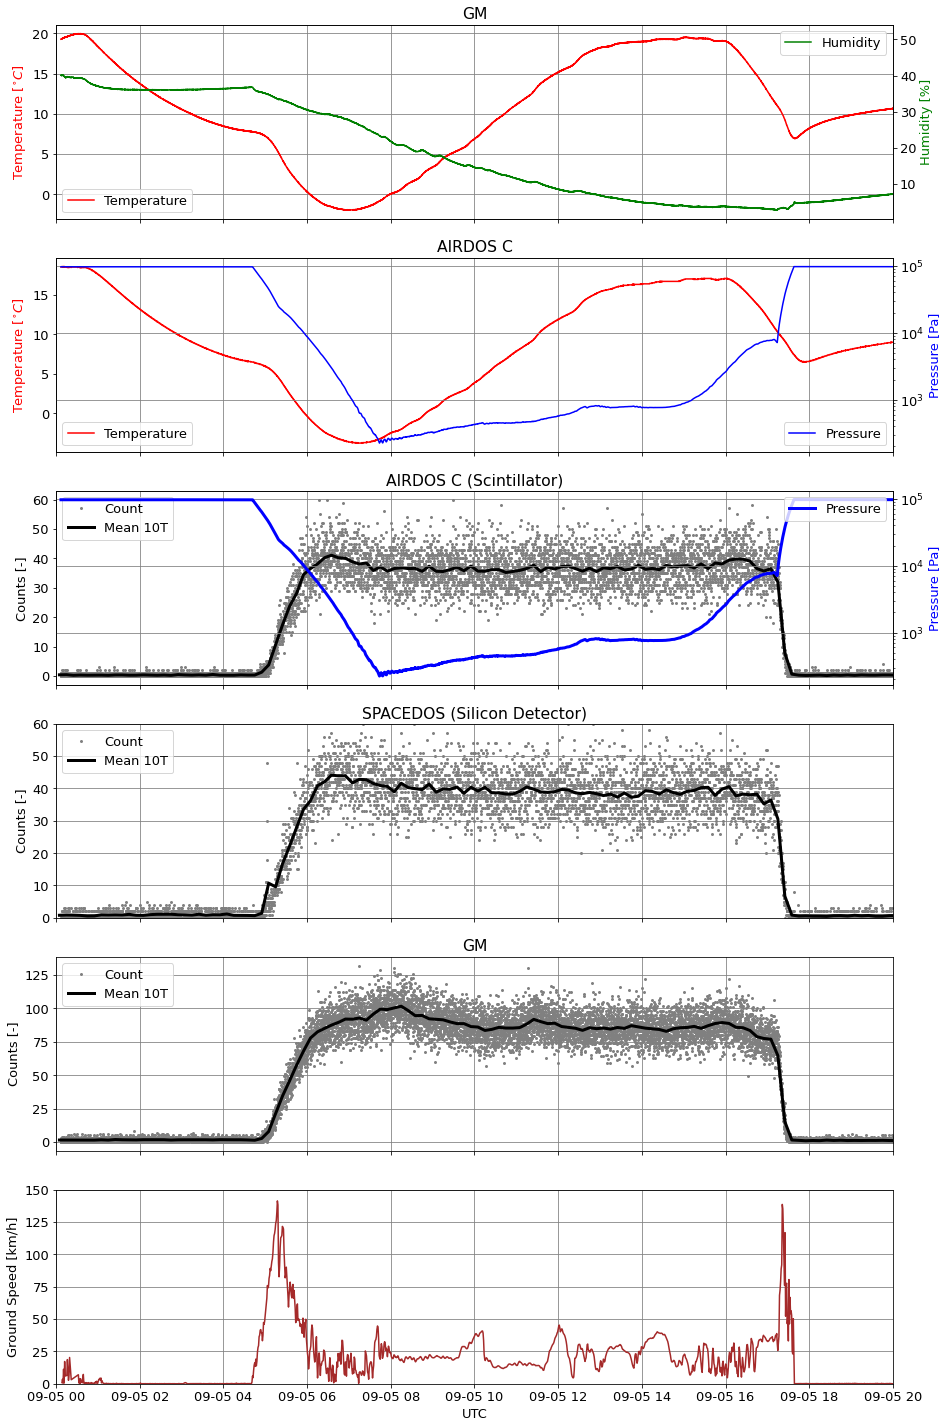

In [3]:
import matplotlib
matplotlib.rcParams.update({'font.size': 13})
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from pandas.tseries.frequencies import to_offset

fig, (ax1, ax3, ax4, ax5, ax2, ax9) \
    = plt.subplots(figsize=(15, 25), nrows=6, sharex=True)
ax1_twin = ax1.twinx()
#ax2_twin = ax2.twinx()
ax3_twin = ax3.twinx()
ax4_twin = ax4.twinx()

MINUTES = 10
WINDOW = str(MINUTES) + 'T'
OFFSET = str(MINUTES/2) + 'T'

def resample_w_loffset(df, window, loffset):
    df = df.resample(WINDOW).mean()
    df.index = df.index + to_offset(loffset)
    return df

# GM
ax2.set_title("GM")
ax2.set_ylabel('Counts [-]')
ax2.plot(gm.index, gm['GMCount'], linestyle='', label='Count', marker='.', markeredgewidth=0, color='gray')
ax2.plot(resample_w_loffset(gm['GMCount'], WINDOW, OFFSET), label='Mean '+WINDOW, lw=3, color='black')
ax2.grid(b=True, which='major', color='grey', linestyle='-', axis='x')
ax2.legend(loc=2)
ax1.set_ylabel('Temperature [$^{\circ}C$]', color='red')
ax1.set_title("GM")
ax1.plot(gm.index, gm['Temp'], color='red', label='Temperature')
ax1.set_xlim('2019-09-05 00:00','2019-09-05 20:00')
ax1.grid(b=True, which='major', color='grey', linestyle='-')
ax1.legend(loc=3)
ax1_twin.set_ylabel('Humidity [%]', color='green')
ax1_twin.plot(gm.index, gm['Humid'], label='Humidity', color='green')
ax1_twin.legend()
ax2.grid(b=True, which='major', color='grey', linestyle='-', axis='y')

# AIRDOS C
spec = np.array(list(map(list, airdos_c_flux['Bins'])))
flux_series = pd.Series(np.sum(spec[:,50:200], axis=1), index=airdos_c_flux.index)

ax4.set_title("AIRDOS C (Scintillator)")
ax4.set_ylabel('Counts [-]')
ax4.plot(flux_series.index, flux_series.values, linestyle='', label='Count', marker='.', markeredgewidth=0, color='gray')
ax4.plot(resample_w_loffset(flux_series, WINDOW, OFFSET), label='Mean '+WINDOW, lw=3, color='black')
ax4.grid(b=True, which='major', color='grey', linestyle='-', axis='x')
ax4.legend(loc=2)
ax3.set_title("AIRDOS C")
ax3.set_ylabel('Temperature [$^{\circ}C$]', color='red')
ax3.plot(airdos_c_flux.index, airdos_c_flux['Temp'], label='Temperature', color='red')
ax3.grid(b=True, which='major', color='grey', linestyle='-', axis='x')
ax3.legend(loc=3)

ax3_twin.set_yscale('log')
ax3_twin.set_ylabel('Pressure [Pa]', color='blue')
ax3_twin.plot(airdos_c_flux.index, airdos_c_flux['Pressure'], label='Pressure', color='blue')
ax3_twin.grid(b=True, which='major', color='grey', linestyle='-')
ax3_twin.legend(loc=4)

ax4_twin.set_yscale('log')
ax4_twin.set_ylabel('Pressure [Pa]', color='blue')
ax4_twin.plot(airdos_c_flux.index, airdos_c_flux['Pressure'],
              color='blue', lw=3, label='Pressure')
ax4_twin.grid(b=True, which='major', color='grey', linestyle='-')
ax4_twin.legend(loc=1)

# SPACEDOS
ax5.set_ylim(0, 60)
ax5.set_title('SPACEDOS (Silicon Detector)')
ax5.set_ylabel('Counts [-]')
ax5.plot(spacedos_flux['Flux'], linestyle='', marker='.', label='Count', markeredgewidth=0, color='gray')
ax5.plot(resample_w_loffset(spacedos_flux['Flux'], WINDOW, OFFSET), lw=3, label='Mean '+WINDOW, color='black')
ax5.grid(b=True, which='major', color='grey', linestyle='-')
ax5.legend(loc=2)

ax9.plot(airdos_c_nav.index, airdos_c_nav['Speed'], color='brown')
ax9.set_ylabel('Ground Speed [km/h]')
ax9.grid(b=True, which='major', color='grey', linestyle='-')
ax9.set_ylim(0,150)
ax9.set_xlabel('UTC')

None

In [4]:
# AIRDOS C channel no. to energy conversion
airdos_ch_to_MeV = lambda ch: (ch*0.191 + 0.32)

# SPACEDOS channel no. to energy conversion
spacedos_ch_to_MeV = lambda ch: (ch*0.038 + 0.105)

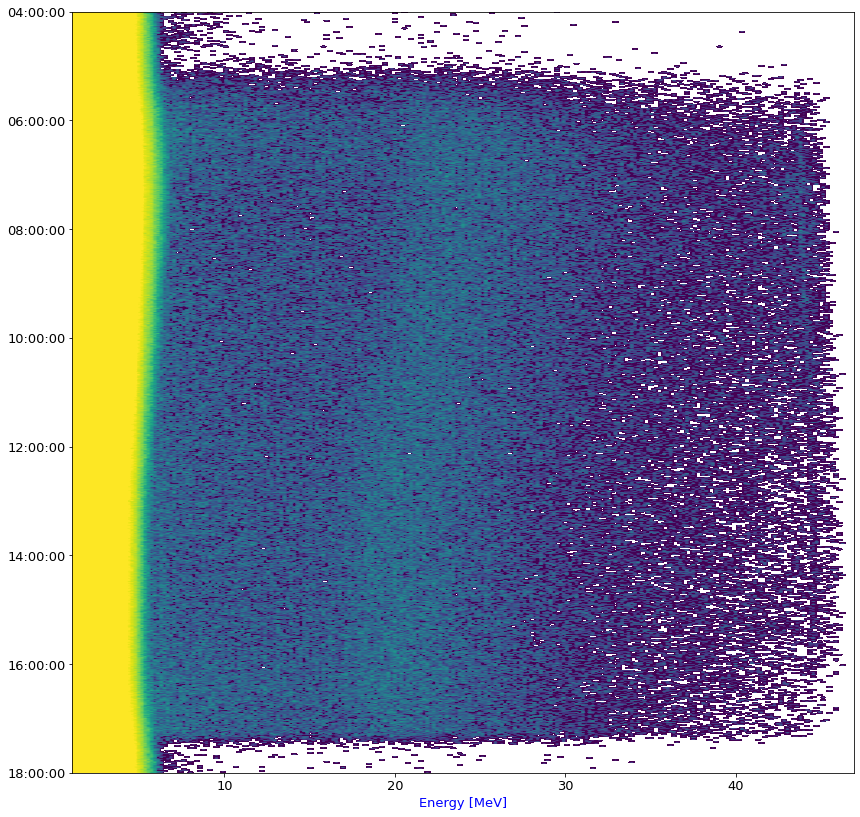

In [5]:
from matplotlib.colors import LogNorm
from matplotlib import dates as mdates

# c_all is pandas frame, c_all['Bins'] contains logged spectra, each spectrum being an ordinary python list
c_all = airdos_c_flux

# select time range of interest
ta = pd.Timestamp('2019-09-05T04', tz='UTC')
tb = pd.Timestamp('2019-09-05T18', tz='UTC')
c = c_all[(c_all.index > ta) & (c_all.index < tb)]

# export spectra to numpy array
spectra = np.array(list(c['Bins']))

# channel range of interest
cha = 4
chb = 244
ch_conversion = airdos_ch_to_MeV

fig, ax = plt.subplots(figsize=(14, 14))
y_lims = [mdates.date2num(ta.to_pydatetime()),
          mdates.date2num(tb.to_pydatetime())]
ax.imshow(spectra[:,cha:chb+1],
          extent=[ch_conversion(cha), ch_conversion(chb), y_lims[1], y_lims[0]],
          aspect='auto', norm=LogNorm(0.05, 20))
ax.yaxis_date()
ax.set_xlabel('Energy [MeV]', color='blue')
date_format = mdates.DateFormatter('%H:%M:%S')
ax.yaxis.set_major_formatter(date_format)
plt.show()

None

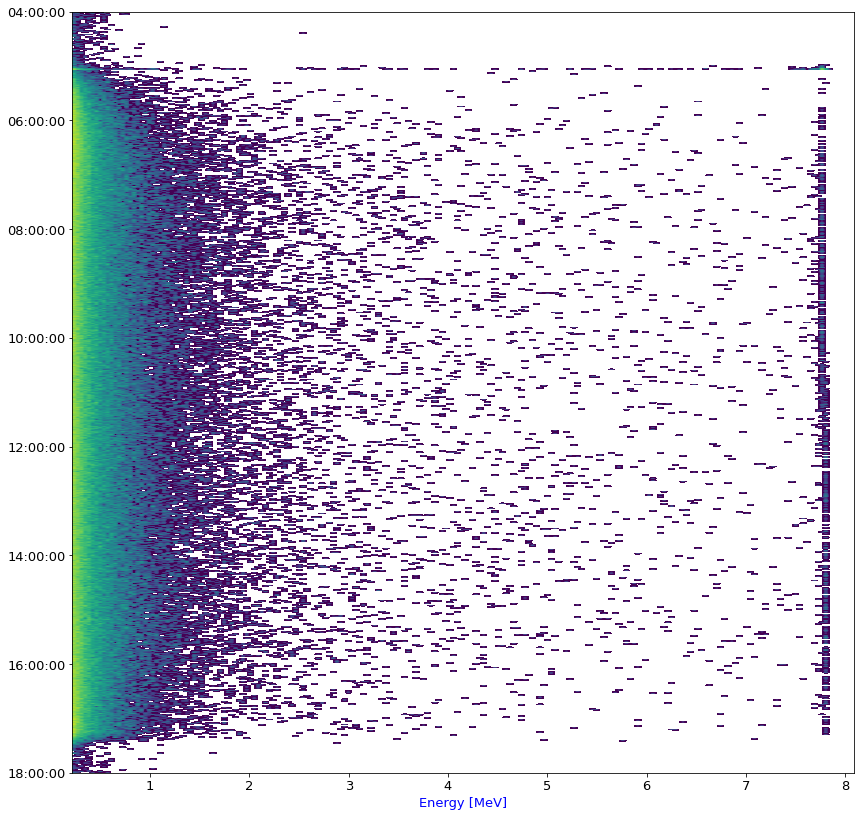

In [6]:
from matplotlib.colors import LogNorm
from matplotlib import dates as mdates

# c_all is pandas frame, c_all['Bins'] contains logged spectra, each spectrum being an ordinary python list
c_all = spacedos_flux

# select time range of interest
ta = pd.Timestamp('2019-09-05T04', tz='UTC')
tb = pd.Timestamp('2019-09-05T18', tz='UTC')
c = c_all[(c_all.index > ta) & (c_all.index < tb)]

# export spectra to numpy array
spectra = np.array(list(c['Bins']))

# channel range of interest
cha = 3
chb = 210
ch_conversion = spacedos_ch_to_MeV

fig, ax = plt.subplots(figsize=(14, 14))
y_lims = [mdates.date2num(ta.to_pydatetime()),
          mdates.date2num(tb.to_pydatetime())]
ax.imshow(spectra[:,cha:chb+1],
          extent=[ch_conversion(cha), ch_conversion(chb), y_lims[1], y_lims[0]],
          aspect='auto', norm=LogNorm(0.05, 20))
ax.yaxis_date()
ax.set_xlabel('Energy [MeV]', color='blue')
date_format = mdates.DateFormatter('%H:%M:%S')
ax.yaxis.set_major_formatter(date_format)
plt.show()

None